In [42]:
import torch
import torch.nn.functional as F
import torchtext
import time
import random
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

In [43]:
print(torch.__version__)

1.8.2+cu111


In [44]:
torch.cuda.is_available()


True

# About the version of package:

1. If you don't want to mass you package version, you can create the virtual environment
only for this project.
please see the detail: https://docs.python.org/3.8/library/venv.html

2. After you create virtual environment, if you use pip, you can install pipreqs package,
it can help you to save you package version and easy to install:

pip install -r .\requirements.txt
please see the detail：https://github.com/bndr/pipreqs

I will provide my package version for you in the file.


3. For this project, The most important is torchtext 0.9, all the minor version is works,
torch 1.8.1 and torchtext 0.9.1 is also work.
If you not use GPU, you can just use torch 1.8.1, which is same as Professor Li publish in blackboard.
If you want to use GPU, please check torch version: https://pytorch.org/get-started/locally/
and torchtext version: https://pypi.org/project/torchtext/

If you have some questions, please contact me.

# The data set is from kaggle youtube  statistics:
https://www.kaggle.com/code/elem3ntary/predicting-comment-sentiment/data

The code is from :https://sebastianraschka.com/blog/2021/dl-course.html

# Comment Sentiment:
0 represents a negative sentiment
1 represent neutral
2 represent positive

In [45]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 20000
LEARNING_RATE = 0.01
BATCH_SIZE = 128
NUM_EPOCHS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 3

In [46]:
print(DEVICE)

cuda


<AxesSubplot: xlabel='Sentiment'>

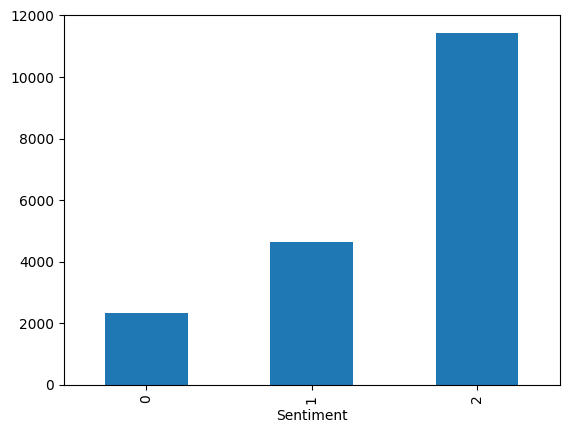

In [47]:
# read the data
comment =  pd.read_csv('comments.csv')
comment.groupby('Sentiment').count()['Comment'].plot.bar()


In [48]:
#look at data
comment.head()

,Unnamed: 0,Video ID,Comment,Likes,Sentiment
0,0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95,1
1,1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19,0
2,2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161,2
3,3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8,0
4,4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34,2


In [49]:
comment.iloc[3,2]

'Whenever I go to a place that doesn’t take Apple Pay (doesn’t happen too often), it’s such a drag. Between ‘contactless Covid’ habits and my getting the Apple Card, I’ve gotten so used to Apple Pay that I get seriously annoyed when a store doesn’t take it. It feels like a shock, it’s crazy how quickly it took over my shopping routine! I’ve officially been brainwashed by Apple because now it feels so inconvenient to even carry a physical card in my pocket.'

In [50]:
# look the data
comment.describe()

,Unnamed: 0,Likes,Sentiment
count,18409.000000,18409.000000,18409.000000
mean,9204.000000,1040.019447,1.493998
std,5314.364888,10651.366148,0.709928
min,0.000000,0.000000,0.000000
25%,4602.000000,5.000000,1.000000
50%,9204.000000,29.000000,2.000000
75%,13806.000000,190.000000,2.000000
max,18408.000000,891372.000000,2.000000


In [51]:
#have 1 null data in comment
comment.isnull().sum()

Unnamed: 0    0
Video ID      0
Comment       1
Likes         0
Sentiment     0
dtype: int64

In [52]:
#look at null data
comment[comment['Comment'].isnull()]


,Unnamed: 0,Video ID,Comment,Likes,Sentiment
9745,9745,bvkk3UdlfA4,NaN,1,1


In [53]:
#drop the other columns, and change 1 and 2 in sentiment to 1
comment_data = comment.drop(columns = ['Unnamed: 0', 'Video ID', 'Likes'])
comment_data.groupby('Sentiment').count()

,Comment
Sentiment,
0,2338
1,4638
2,11432


In [54]:
#change column name
comment_data.columns = ['TEXT_COLUMN_NAME', 'LABEL_COLUMN_NAME']

In [55]:
comment_data.to_csv('youtube_data.csv', index=None)
comment_look = pd.read_csv('youtube_data.csv')



Download English vocabulary via:

- `python -m spacy download en_core_web_sm`



In [56]:
# only have legacy in torchtext==0.9
# pip install torchtext==0.9
### Defining the feature processing

TEXT = torchtext.legacy.data.Field(
    tokenize='spacy', # default splits on whitespace
    tokenizer_language='en_core_web_sm'
)

### Defining the label processing

LABEL = torchtext.legacy.data.LabelField(dtype=torch.long)


In [57]:
fields = [('TEXT_COLUMN_NAME', TEXT), ('LABEL_COLUMN_NAME', LABEL)]

dataset = torchtext.legacy.data.TabularDataset(
    path='youtube_data.csv', format='csv',
    skip_header=True, fields=fields)



In [58]:
# separate into train and test set
train_data, test_data = dataset.split(
    split_ratio=[0.8, 0.2],
    random_state=random.seed(RANDOM_SEED))

print(f'Num Train: {len(train_data)}')
print(f'Num Test: {len(test_data)}')


Num Train: 14727
Num Test: 3682


In [59]:
# separate into train, valid and test set
train_data, valid_data = train_data.split(
    split_ratio=[0.85, 0.15],
    random_state=random.seed(RANDOM_SEED))

print(f'Num Train: {len(train_data)}')
print(f'Num Validation: {len(valid_data)}')


Num Train: 12518
Num Validation: 2209


In [60]:
print(vars(train_data.examples[0]))


{'TEXT_COLUMN_NAME': ['Definitely', 'trying', 'this', 'tomorrow', 'on', 'my', 'son', '.', 'This', 'cut', 'is', 'detailed', 'with', 'all', 'the', 'instructions', '.', 'Appreciate', 'you', 'sharing', 'this', 'knowledge', ',', 'stay', 'blessed', 'my', 'brother'], 'LABEL_COLUMN_NAME': '2'}


## Build Vocabulary

Build the vocabulary based on the top "VOCABULARY_SIZE" words:

In [61]:
TEXT.build_vocab(train_data, max_size=VOCABULARY_SIZE)
LABEL.build_vocab(train_data)

print(f'Vocabulary size: {len(TEXT.vocab)}')
print(f'Number of classes: {len(LABEL.vocab)}')

Vocabulary size: 20002
Number of classes: 3


- 20,002 not 20,000 because of the `<unk>` and `<pad>` tokens
- PyTorch RNNs can deal with arbitrary lengths due to dynamic graphs, but padding is necessary for padding sequences to the same length in a given minibatch so we can store those in an array

In [62]:
#Look at most common words:
print(TEXT.vocab.freqs.most_common(20))


[('.', 17588), ('the', 13963), (',', 12709), ('I', 10643), ('to', 10043), ('and', 9479), ('a', 8730), ('of', 6448), ('\n', 6438), ('!', 5617), ('is', 5523), ('you', 5371), ('in', 5036), ('it', 4599), ('for', 4536), ('that', 4096), ('this', 3756), ('"', 2630), ('on', 2556), ('my', 2515)]


In [63]:
#Tokens corresponding to the first 10 indices (0, 1, ..., 9):
print(TEXT.vocab.itos[:10]) # itos = integer-to-string



['<unk>', '<pad>', '.', 'the', ',', 'I', 'to', 'and', 'a', 'of']


**Converting a string to an integer:**

In [64]:
print(TEXT.vocab.stoi['the']) # stoi = string-to-integer

3


**Class labels:**

In [65]:
print(LABEL.vocab.stoi)

defaultdict(None, {'2': 0, '1': 1, '0': 2})


**Class label count:**

In [66]:
LABEL.vocab.freqs

Counter({'2': 7722, '1': 3174, '0': 1622})

## Define Data Loaders

In [67]:
train_loader, valid_loader, test_loader = \
    torchtext.legacy.data.BucketIterator.splits(
        (train_data, valid_data, test_data),
         batch_size=BATCH_SIZE,
         sort_within_batch=False,
         sort_key=lambda x: len(x.TEXT_COLUMN_NAME),
         device=DEVICE
    )

Testing the iterators (note that the number of rows depends on the longest document in the respective batch):

In [68]:
print('Train')
for batch in train_loader:
    print(f'Text matrix size: {batch.TEXT_COLUMN_NAME.size()}')
    print(f'Target vector size: {batch.LABEL_COLUMN_NAME.size()}')
    break

print('\nValid:')
for batch in valid_loader:
    print(f'Text matrix size: {batch.TEXT_COLUMN_NAME.size()}')
    print(f'Target vector size: {batch.LABEL_COLUMN_NAME.size()}')
    break

print('\nTest:')
for batch in test_loader:
    print(f'Text matrix size: {batch.TEXT_COLUMN_NAME.size()}')
    print(f'Target vector size: {batch.LABEL_COLUMN_NAME.size()}')
    break

Train
Text matrix size: torch.Size([718, 128])
Target vector size: torch.Size([128])

Valid:
Text matrix size: torch.Size([8, 128])
Target vector size: torch.Size([128])

Test:
Text matrix size: torch.Size([6, 128])
Target vector size: torch.Size([128])


## Model

In [69]:
class RNN(torch.nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        #self.rnn = torch.nn.RNN(embedding_dim,
        #                        hidden_dim,
        #                        nonlinearity='relu')
        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim)

        self.fc = torch.nn.Linear(hidden_dim, output_dim)


    def forward(self, text):
        # text dim: [sentence length, batch size]

        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]

        output, (hidden, cell) = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]

        hidden.squeeze_(0)
        # hidden dim: [batch size, hidden dim]

        output = self.fc(hidden)
        return output

In [70]:
torch.manual_seed(RANDOM_SEED)
model = RNN(input_dim=len(TEXT.vocab),
            embedding_dim=EMBEDDING_DIM,
            hidden_dim=HIDDEN_DIM,
            output_dim=NUM_CLASSES # could use 1 for binary classification
)

model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

## Training

In [71]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


In [72]:
def predict_label(model, data_loader, device):

    with torch.no_grad():
        Y_acctual, Y_preds = [], []
        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
            Y_preds.append(predicted_labels.cpu().data.numpy())
            Y_acctual.append(targets.cpu().data.numpy())
    return  np.concatenate(Y_preds), np.concatenate(Y_acctual)

In [73]:
start_time = time.time()

train_accuracy = []
valid_accuracy = []

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):

        text = batch_data.TEXT_COLUMN_NAME.to(DEVICE)
        labels = batch_data.LABEL_COLUMN_NAME.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits = model(text)
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()

        loss.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:

            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                   f'Loss: {loss:.4f}')

    with torch.set_grad_enabled(False):
        train_accuracy.append(float(f'{compute_accuracy(model, train_loader, DEVICE):.2f}'))
        valid_accuracy.append(float(f'{compute_accuracy(model, valid_loader, DEVICE):.2f}'))
        print(f'training accuracy: '
              f'{compute_accuracy(model, train_loader, DEVICE):.2f}%'
              f'\nvalid accuracy: '
              f'{compute_accuracy(model, valid_loader, DEVICE):.2f}%')

    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')

print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f}%')


Epoch: 001/100 | Batch 000/098 | Loss: 1.1501
Epoch: 001/100 | Batch 050/098 | Loss: 0.8992
training accuracy: 61.85%
valid accuracy: 57.85%
Time elapsed: 0.29 min
Epoch: 002/100 | Batch 000/098 | Loss: 0.8820
Epoch: 002/100 | Batch 050/098 | Loss: 0.9585
training accuracy: 61.87%
valid accuracy: 61.20%
Time elapsed: 0.58 min
Epoch: 003/100 | Batch 000/098 | Loss: 0.8801
Epoch: 003/100 | Batch 050/098 | Loss: 0.9243
training accuracy: 61.98%
valid accuracy: 59.57%
Time elapsed: 0.87 min
Epoch: 004/100 | Batch 000/098 | Loss: 0.9145
Epoch: 004/100 | Batch 050/098 | Loss: 0.8209
training accuracy: 62.00%
valid accuracy: 59.94%
Time elapsed: 1.17 min
Epoch: 005/100 | Batch 000/098 | Loss: 0.8168
Epoch: 005/100 | Batch 050/098 | Loss: 0.9346
training accuracy: 62.05%
valid accuracy: 59.94%
Time elapsed: 1.45 min
Epoch: 006/100 | Batch 000/098 | Loss: 0.9650
Epoch: 006/100 | Batch 050/098 | Loss: 0.8961
training accuracy: 62.08%
valid accuracy: 58.71%
Time elapsed: 1.75 min
Epoch: 007/100 |

In [74]:


nlp = spacy.blank("en")

def predict_sentiment(model, sentence):

    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(DEVICE)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.nn.functional.softmax(model(tensor), dim=1)
    return prediction[0][0].item()

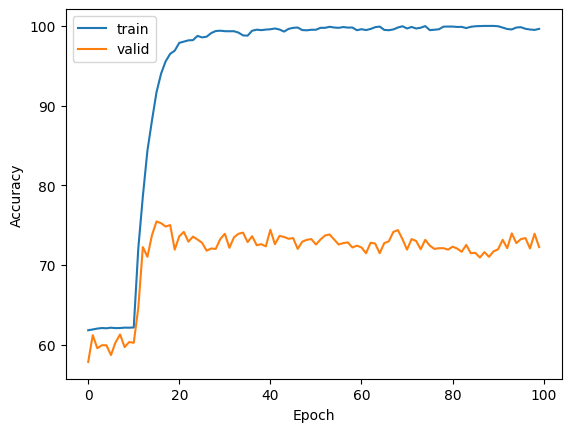

In [75]:
plt.plot(train_accuracy, label = 'train')
plt.plot(valid_accuracy, label = 'valid')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('accuracy.png')

In [76]:
print('Probability positive:')
predict_sentiment(model, "This is such an awesome movie, I really love it!")


Probability positive:


0.9991523027420044

In [77]:
print('Probability negative:')
1-predict_sentiment(model, "Whenever I go to a place that doesn’t take Apple Pay (doesn’t happen too often), it’s such a drag. Between ‘contactless Covid’ habits and my getting the Apple Card, I’ve gotten so used to Apple Pay that I get seriously annoyed when a store doesn’t take it. It feels like a shock, it’s crazy how quickly it took over my shopping routine! I’ve officially been brainwashed by Apple because now it feels so inconvenient to even carry a physical card in my pocket")

Probability negative:


0.9999780166144774

In [78]:
predict_label, real_label= predict_label(model, test_loader, DEVICE)
print(predict_label, real_label)

[0 0 0 ... 1 1 1] [1. 0. 1. ... 2. 1. 1.]


In [79]:
#confuion matrix

cf_matrix = confusion_matrix(real_label, predict_label)
cf_matrix

array([[1931,  254,  138],
       [ 233,  495,  177],
       [  94,  159,  201]], dtype=int64)

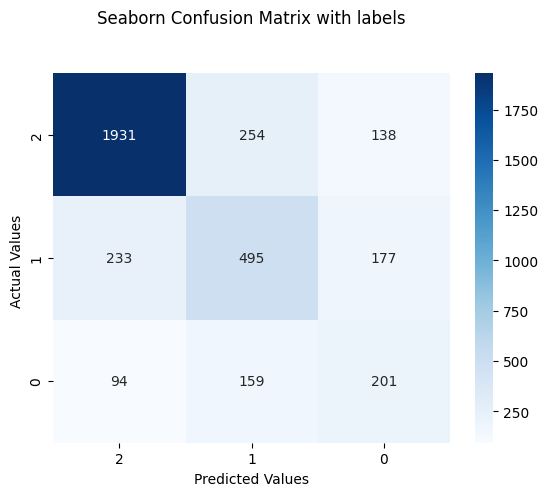

In [80]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt = '.20g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['2','1','0'])
ax.yaxis.set_ticklabels(['2','1','0'])

plt.savefig('confusion_matrix.png')
## Display the visualization of the Confusion Matrix.
plt.show()